In [ ]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

import os
from glob import glob
import fnmatch 


from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score

import tensorflow as tf
import keras

import tensorflow.keras
from keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, Adamax, Nadam, Ftrl
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D

In [ ]:
#getting file from google drive to show up in google colab files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#To extract Google Drive zip from a Google colab notebook:
#unzipping file 
import zipfile

#unzipping train dataset
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/pathology_images/18k_pathology_images.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [ ]:
#generating data (fetch data, then count number of images and classes)
image_size=(100,100)
batch_size=32

#fetching train dataset from directory 
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    "18k_pathology_images/train", #training dataset path (location)
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)


#fetching validation dataset from directory 
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    "18k_pathology_images/validation", #validation dataset path (location)
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 9938 files belonging to 2 classes.
Found 4719 files belonging to 2 classes.


In [ ]:
#base_dir is the folder where the images are stored
base_dir="/content/18k_pathology_images"

train_dir=os.path.join(base_dir, "train")
validation_dir=os.path.join(base_dir, "validation")

train_neg_dir=os.path.join(train_dir, "*class0.png")
train_pos_dir=os.path.join(train_dir, "*class1.png")

validation_neg_dir=os.path.join(validation_dir, "*class0.png")
validation_pos_dir=os.path.join(validation_dir, "*class1.png")

In [ ]:
#loading Train dataset 
#glob module retrieves files and pathnames
histo_images=glob("/content/18k_pathology_images/**/*.png", recursive=True)

#how many images are in the folder?
total_image_count=len(histo_images)
print(f"There are {total_image_count} images")

There are 14657 images


In [ ]:
#how many class 0s and 1s do we have in the ds?
print("Dataset Class Distributions: \n")


zeros_train="*class0.png"
ones_train="*class1.png"

#fnmatch() compares a single file name against a pattern and returns TRUE if they match else returns FALSE. 
class0_train=fnmatch.filter(histo_images, zeros_train)
class1_train=fnmatch.filter(histo_images, ones_train)

#counting how many 0s and 1s there are
count_class0_train=len(class0_train)
count_class1_train=len(class1_train)
print(f"There are {count_class0_train} of class 0.")
print(f"There are {count_class1_train} of class 1.")

#getting percentages of each class
percentage_0_train=((count_class0_train)/(total_image_count))*100
percentage_1_train=((count_class1_train)/(total_image_count))*100

#rounding percentage to 2 decimal places
percentage_0_train=np.round(percentage_0_train, 2)
percentage_1_train=np.round(percentage_1_train, 2)

#what percenatage are each class?
print(f"{percentage_0_train}% of the images are class 0.")
print(f"{percentage_1_train}% of the image are class 1.")

Dataset Class Distributions: 

There are 9357 of class 0.
There are 5300 of class 1.
63.84% of the images are class 0.
36.16% of the image are class 1.


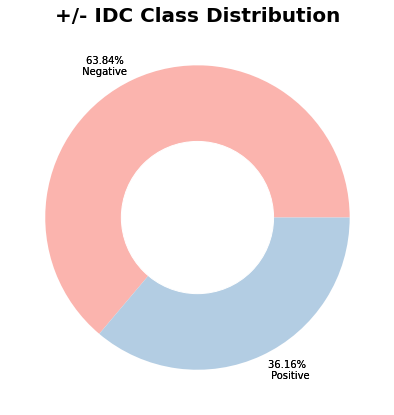

In [ ]:
#creating a donut plot
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))

#text contained in the border
class_dist = ["63.84% \n Negative", "36.16% \n Positive"]
#distribution size
data=[63.84, 36.16] 

ax.set_title("+/- IDC Class Distribution", 
             weight='heavy', fontsize=20)

#Customizing Text/Label color
plt.rcParams['text.color'] = 'black'
# Custom wedges' width and width color 
plt.pie(data, labels=class_dist, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' })


# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.5, color='white')

from palettable.colorbrewer.qualitative import Pastel1_7
plt.pie(data, labels=class_dist, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()

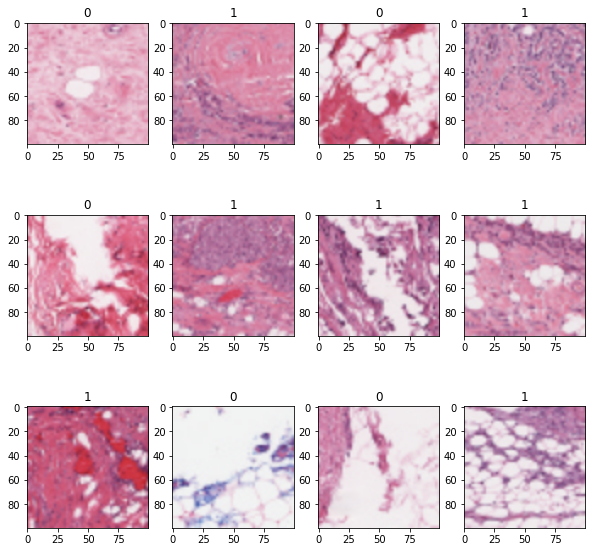

In [ ]:
#visualizing the data 
#these are images from the train set. 

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax=plt.subplot(3,4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("on")

In [ ]:
#using image data augmentation for sample diversity to reduce overfitting
#apply to training ds, but no need to apply to validation ds

data_augmentation=keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

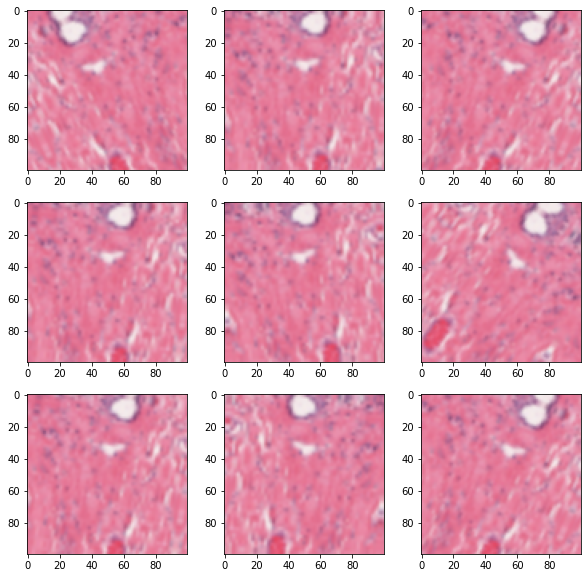

In [ ]:
#visualizing the augmented sample by applying data_augmentation 
# displaying one of the images in the train ds 


for images, _ in train_ds.take(1):
  plt.figure(figsize=(10,10))
  first_image=images[0]
  for i in range(9):
    augmented_images=data_augmentation(tf.expand_dims(first_image,0))
    ax=plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0]/255)
    plt.axis("on") 

In [ ]:
#rescaling pixel values
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
#creating base model from pre-trained models 

In [ ]:
#deep learning model chosen is Xception from Keras Applications 
#Xception requires atleast 71x71 image size

base_model=tf.keras.applications.Xception(
    weights="imagenet",
    input_shape=(100,100,3),
    include_top=False #not including the classification layers at the top, which is ideal for feature extraction
)

#base_model.summary()

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


The feature extractor convverted the (50,50,3) image into a 5,5,1280 block of features. 

In [ ]:
#freezing the convolutional base to prevent weights in given layer from 
#being updated during training 

#pre-trained model MobileNetV2 has many layers so setting the model's trainable to False, freezes them.
base_model.trainable=False

#if want to see layers use code below: 
#for layer in base_model.layers:
  #layer.trainable=False
  #print("Layer " + layer.name + " is now frozen.")

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
#adding a classification head to generate predictions 
#from the 

#Global Average Pooling calculates the average output of each feature map in the 
#...previous layer. This reduces the data and prepares the model for the final 
#... classification layer.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
#applying a Dense layer to convert the features into a single predication per image.
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
#Building a model by integrating all modifications such as data augmentations and
#rescaling. Also incorporating base_model and feature extractor layers
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 100, 100, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 100, 100, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

# Xception Model usign optimizer Adam with lr=0.00001

In [ ]:
#compiling the model before training 
#using binary cross-entropy because there are two classes 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#training the model 
initial_epochs=60

loss0, accuracy0=model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

148/148 [==============================] - 7s 40ms/step - loss: 51.8204 - accuracy: 0.7219
initial loss: 52.62
initial accuracy: 0.72


In [ ]:
#training the model 
initial_epochs=60

loss0, accuracy0=model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

148/148 [==============================] - 6s 39ms/step - loss: 52.6180 - accuracy: 0.7158
initial loss: 52.62
initial accuracy: 0.72


In [ ]:
# note: better predictions should lead to lower loss and higher accuracy

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/60
311/311 [==============================] - 18s 59ms/step - loss: 18.9372 - accuracy: 0.8058 - val_loss: 52.5399 - val_accuracy: 0.7160
Epoch 2/60
311/311 [==============================] - 19s 59ms/step - loss: 18.8298 - accuracy: 0.8060 - val_loss: 52.5005 - val_accuracy: 0.7163
Epoch 3/60
311/311 [==============================] - 18s 58ms/step - loss: 19.2849 - accuracy: 0.7974 - val_loss: 52.4621 - val_accuracy: 0.7165
Epoch 4/60
311/311 [==============================] - 18s 59ms/step - loss: 18.8398 - accuracy: 0.8000 - val_loss: 52.4175 - val_accuracy: 0.7167
Epoch 5/60
311/311 [==============================] - 18s 58ms/step - loss: 18.3352 - accuracy: 0.8095 - val_loss: 52.3807 - val_accuracy: 0.7167
Epoch 6/60
311/311 [==============================] - 18s 58ms/step - loss: 18.3274 - accuracy: 0.8086 - val_loss: 52.3492 - val_accuracy: 0.7167
Epoch 7/60
311/311 [==============================] - 18s 59ms/step - loss: 18.2808 - accuracy: 0.8118 - val_loss: 52.3075 -

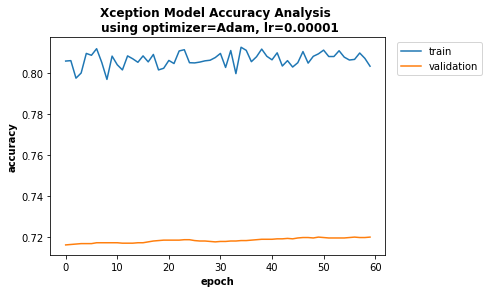

In [ ]:
#performance analysis for model 

#show the trend of the model accuracy 

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch",weight='heavy')
plt.ylabel("accuracy",weight='heavy')
plt.title("Xception Model Accuracy Analysis \n using optimizer=Adam, lr=0.00001", weight='heavy', fontsize=12)
#placing legend out 
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

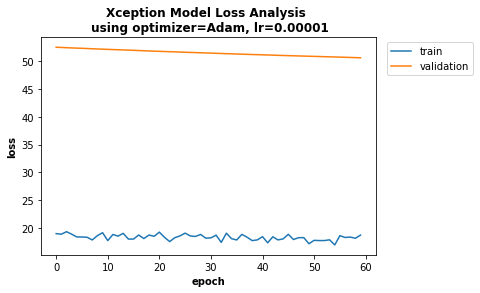

In [ ]:
#performance analysis for model 

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss",weight='heavy')
plt.xlabel("epoch",weight='heavy')
plt.title("Xception Model Loss Analysis \n using optimizer=Adam, lr=0.00001", weight='heavy', fontsize=12)
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

# Xception Model usign optimizer Adam with lr=0.0001


In [ ]:
#compiling the model before training 
#using binary cross-entropy because there are two classes 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#training the model 
initial_epochs=30

loss0, accuracy0=model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

148/148 [==============================] - 8s 42ms/step - loss: 0.7008 - accuracy: 0.6111
initial loss: 0.70
initial accuracy: 0.62


In [ ]:
# note: better predictions should lead to lower loss and higher accuracy

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
311/311 [==============================] - 22s 61ms/step - loss: 0.6229 - accuracy: 0.6298 - val_loss: 0.5867 - val_accuracy: 0.6720
Epoch 2/30
311/311 [==============================] - 18s 58ms/step - loss: 0.5652 - accuracy: 0.6586 - val_loss: 0.5771 - val_accuracy: 0.6796
Epoch 3/30
311/311 [==============================] - 18s 58ms/step - loss: 0.5367 - accuracy: 0.6818 - val_loss: 0.5769 - val_accuracy: 0.6889
Epoch 4/30
311/311 [==============================] - 18s 58ms/step - loss: 0.5160 - accuracy: 0.7047 - val_loss: 0.5739 - val_accuracy: 0.6938
Epoch 5/30
311/311 [==============================] - 18s 58ms/step - loss: 0.5027 - accuracy: 0.7184 - val_loss: 0.5771 - val_accuracy: 0.7059
Epoch 6/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4911 - accuracy: 0.7355 - val_loss: 0.5735 - val_accuracy: 0.7137
Epoch 7/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4818 - accuracy: 0.7417 - val_loss: 0.5741 - val_accuracy:

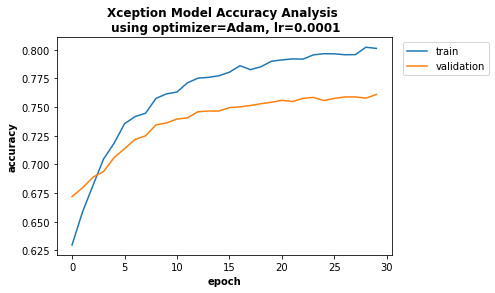

In [ ]:
#performance analysis for model 

#show the trend of the model accuracy 

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch",weight='heavy')
plt.ylabel("accuracy",weight='heavy')
plt.title("Xception Model Accuracy Analysis \n using optimizer=Adam, lr=0.0001", weight='heavy', fontsize=12)
#placing legend out 
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

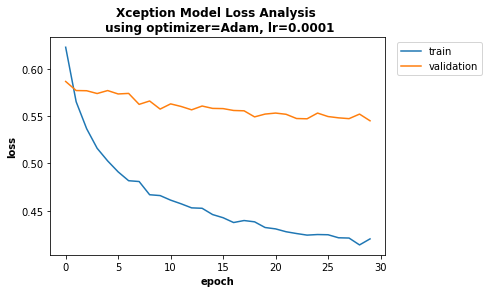

In [ ]:
#performance analysis for model 

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss",weight='heavy')
plt.xlabel("epoch",weight='heavy')
plt.title("Xception Model Loss Analysis \n using optimizer=Adam, lr=0.00001", weight='heavy', fontsize=12)
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

# Xception Model usign optimizer Adam with lr=0.001


In [ ]:
#compiling the model before training 
#using binary cross-entropy because there are two classes 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#training the model 
initial_epochs=30

loss0, accuracy0=model.evaluate(val_ds)

148/148 [==============================] - 7s 39ms/step - loss: 0.5517 - accuracy: 0.7519


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.55
initial accuracy: 0.76


In [ ]:
# note: better predictions should lead to lower loss and higher accuracy

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
311/311 [==============================] - 21s 58ms/step - loss: 0.4223 - accuracy: 0.8013 - val_loss: 0.5337 - val_accuracy: 0.7705
Epoch 2/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4073 - accuracy: 0.8079 - val_loss: 0.5573 - val_accuracy: 0.7703
Epoch 3/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4050 - accuracy: 0.8114 - val_loss: 0.5426 - val_accuracy: 0.7724
Epoch 4/30
311/311 [==============================] - 18s 58ms/step - loss: 0.3994 - accuracy: 0.8129 - val_loss: 0.5805 - val_accuracy: 0.7646
Epoch 5/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4018 - accuracy: 0.8179 - val_loss: 0.5745 - val_accuracy: 0.7644
Epoch 6/30
311/311 [==============================] - 18s 58ms/step - loss: 0.3969 - accuracy: 0.8195 - val_loss: 0.5850 - val_accuracy: 0.7639
Epoch 7/30
311/311 [==============================] - 18s 58ms/step - loss: 0.3912 - accuracy: 0.8201 - val_loss: 0.5838 - val_accuracy:

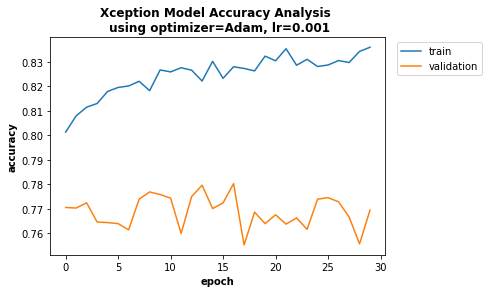

In [ ]:
#performance analysis for model 

#show the trend of the model accuracy 

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch",weight='heavy')
plt.ylabel("accuracy",weight='heavy')
plt.title("Xception Model Accuracy Analysis \n using optimizer=Adam, lr=0.001", weight='heavy', fontsize=12)
#placing legend out 
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

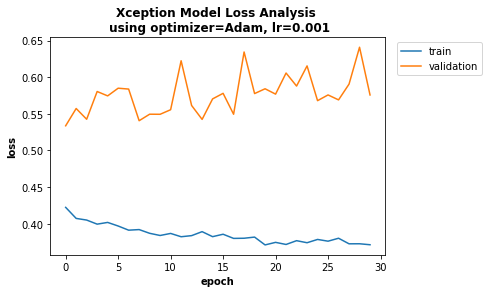

In [ ]:
#performance analysis for model 

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss",weight='heavy')
plt.xlabel("epoch",weight='heavy')
plt.title("Xception Model Loss Analysis \n using optimizer=Adam, lr=0.001", weight='heavy', fontsize=12)
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

## Xception Model using learning rate=0.01 and optimizer=Adam

In [ ]:
#compiling the model before training 
#using binary cross-entropy because there are two classes 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#training the model 
initial_epochs=30

loss0, accuracy0=model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

148/148 [==============================] - 7s 39ms/step - loss: 0.5743 - accuracy: 0.7653
initial loss: 0.58
initial accuracy: 0.77


In [ ]:
# note: better predictions should lead to lower loss and higher accuracy

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
311/311 [==============================] - 21s 59ms/step - loss: 0.4656 - accuracy: 0.8108 - val_loss: 0.7542 - val_accuracy: 0.7538
Epoch 2/30
311/311 [==============================] - 18s 59ms/step - loss: 0.4458 - accuracy: 0.8185 - val_loss: 0.6300 - val_accuracy: 0.7855
Epoch 3/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4471 - accuracy: 0.8196 - val_loss: 0.8302 - val_accuracy: 0.7370
Epoch 4/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4631 - accuracy: 0.8217 - val_loss: 0.7828 - val_accuracy: 0.7597
Epoch 5/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4506 - accuracy: 0.8247 - val_loss: 0.8162 - val_accuracy: 0.7466
Epoch 6/30
311/311 [==============================] - 18s 59ms/step - loss: 0.4624 - accuracy: 0.8183 - val_loss: 0.8729 - val_accuracy: 0.7338
Epoch 7/30
311/311 [==============================] - 18s 58ms/step - loss: 0.4718 - accuracy: 0.8184 - val_loss: 0.6594 - val_accuracy:

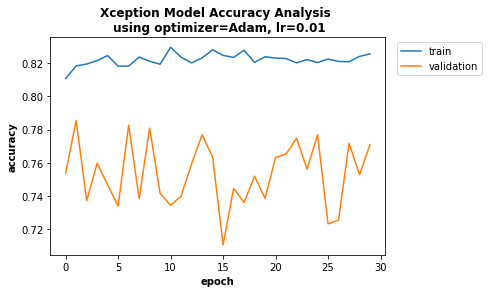

In [ ]:
#performance analysis for model 

#show the trend of the model accuracy 

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch",weight='heavy')
plt.ylabel("accuracy",weight='heavy')
plt.title("Xception Model Accuracy Analysis \n using optimizer=Adam, lr=0.01", weight='heavy', fontsize=12)
#placing legend out 
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

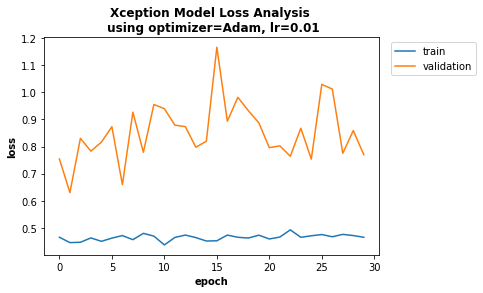

In [ ]:
#performance analysis for model 

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss",weight='heavy')
plt.xlabel("epoch",weight='heavy')
plt.title("Xception Model Loss Analysis \n using optimizer=Adam, lr=0.01", weight='heavy', fontsize=12)
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

## Xception Model using learning rate=0.1 and optimizer=Adam

In [ ]:
#compiling the model before training 
#using binary cross-entropy because there are two classes 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#training the model 
initial_epochs=30

loss0, accuracy0=model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

148/148 [==============================] - 7s 39ms/step - loss: 0.7552 - accuracy: 0.7699
initial loss: 0.77
initial accuracy: 0.77


In [ ]:
# note: better predictions should lead to lower loss and higher accuracy

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
311/311 [==============================] - 21s 58ms/step - loss: 1.6428 - accuracy: 0.7719 - val_loss: 2.1057 - val_accuracy: 0.7654
Epoch 2/30
311/311 [==============================] - 18s 58ms/step - loss: 1.5551 - accuracy: 0.7866 - val_loss: 3.2925 - val_accuracy: 0.7442
Epoch 3/30
311/311 [==============================] - 18s 58ms/step - loss: 1.6982 - accuracy: 0.7830 - val_loss: 2.7540 - val_accuracy: 0.7506
Epoch 4/30
311/311 [==============================] - 18s 58ms/step - loss: 1.9717 - accuracy: 0.7835 - val_loss: 3.3749 - val_accuracy: 0.7459
Epoch 5/30
311/311 [==============================] - 18s 58ms/step - loss: 1.7318 - accuracy: 0.7964 - val_loss: 3.2742 - val_accuracy: 0.7408
Epoch 6/30
311/311 [==============================] - 18s 58ms/step - loss: 1.8233 - accuracy: 0.7930 - val_loss: 3.8488 - val_accuracy: 0.7035
Epoch 7/30
311/311 [==============================] - 18s 58ms/step - loss: 2.0423 - accuracy: 0.7893 - val_loss: 4.7385 - val_accuracy:

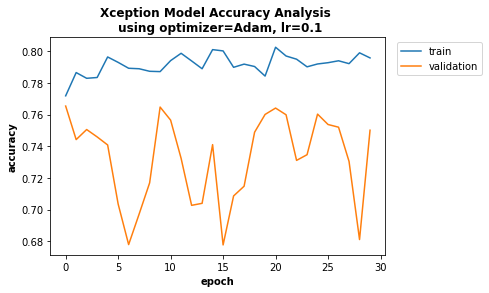

In [ ]:
#performance analysis for model 

#show the trend of the model accuracy 

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch",weight='heavy')
plt.ylabel("accuracy",weight='heavy')
plt.title("Xception Model Accuracy Analysis \n using optimizer=Adam, lr=0.1", weight='heavy', fontsize=12)
#placing legend out 
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

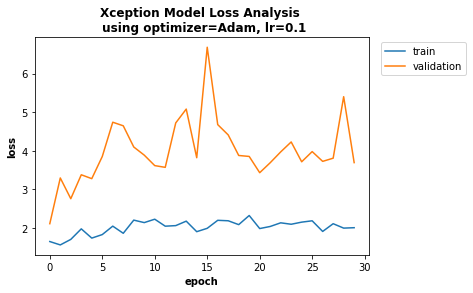

In [ ]:
#performance analysis for model 

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss",weight='heavy')
plt.xlabel("epoch",weight='heavy')
plt.title("Xception Model Loss Analysis \n using optimizer=Adam, lr=0.1", weight='heavy', fontsize=12)
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

# Xception Model with optimizer=Adam and learning rate = 1

In [ ]:
#compiling the model before training 
#using binary cross-entropy because there are two classes 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.0),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#training the model 
initial_epochs=30

loss0, accuracy0=model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

148/148 [==============================] - 7s 39ms/step - loss: 3.7785 - accuracy: 0.7531
initial loss: 3.69
initial accuracy: 0.75


In [ ]:
# note: better predictions should lead to lower loss and higher accuracy

history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/30
311/311 [==============================] - 21s 58ms/step - loss: 14.1950 - accuracy: 0.7541 - val_loss: 24.8054 - val_accuracy: 0.7044
Epoch 2/30
311/311 [==============================] - 18s 58ms/step - loss: 17.2423 - accuracy: 0.7693 - val_loss: 30.1573 - val_accuracy: 0.7487
Epoch 3/30
311/311 [==============================] - 18s 58ms/step - loss: 17.0212 - accuracy: 0.7788 - val_loss: 39.1677 - val_accuracy: 0.7529
Epoch 4/30
311/311 [==============================] - 18s 58ms/step - loss: 17.5680 - accuracy: 0.7793 - val_loss: 29.6503 - val_accuracy: 0.7362
Epoch 5/30
311/311 [==============================] - 18s 57ms/step - loss: 18.3128 - accuracy: 0.7761 - val_loss: 41.4668 - val_accuracy: 0.7141
Epoch 6/30
311/311 [==============================] - 18s 58ms/step - loss: 20.0226 - accuracy: 0.7820 - val_loss: 34.0993 - val_accuracy: 0.7432
Epoch 7/30
311/311 [==============================] - 18s 58ms/step - loss: 18.6621 - accuracy: 0.7869 - val_loss: 54.7825 -

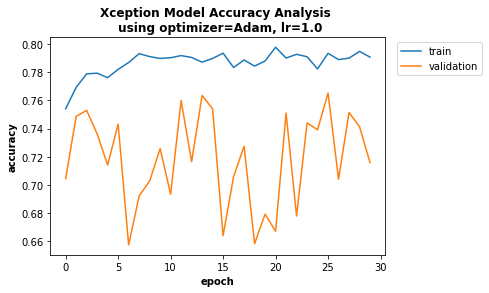

In [ ]:
#performance analysis for model 

#show the trend of the model accuracy 

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("epoch",weight='heavy')
plt.ylabel("accuracy",weight='heavy')
plt.title("Xception Model Accuracy Analysis \n using optimizer=Adam, lr=1.0", weight='heavy', fontsize=12)
#placing legend out 
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')
plt.show()

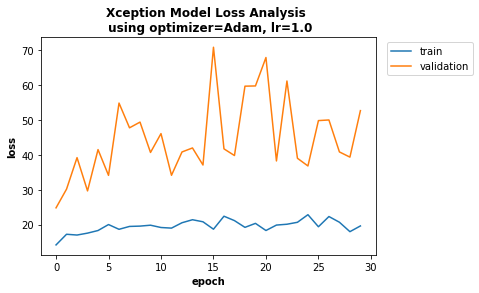

In [ ]:
#performance analysis for model 

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("loss",weight='heavy')
plt.xlabel("epoch",weight='heavy')
plt.title("Xception Model Loss Analysis \n using optimizer=Adam, lr=1.0", weight='heavy', fontsize=12)
plt.legend(["train", "validation"],bbox_to_anchor=(1.02, 1.0), loc='upper left')

plt.show()

#[ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/)

* save_best_only=True 

In [ ]:
# note: better predictions should lead to lower loss and higher accuracy


#history = model.fit(train_ds,
                    #epochs=initial_epochs,
                    #validation_data=val_ds,
                    #callbacks=[model_checkpoint_callback])